# Figures, Part 1

## Setup packages.

In [1]:
require(data.table)
require(magrittr)
require(sensitivity)

require(ggplot2)

Loading required package: data.table
Loading required package: magrittr
Loading required package: sensitivity
Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr
Loading required package: ggplot2


## Read files.

### Read design.

In [2]:
z.design <- fread("design-ee.tsv")
z.design %>% dim

[1] 42500    84

### Read inputs.

In [3]:
z.inputs <- fread("inputs-ee.tsv")
z.inputs %>% dim

[1] 42500    85

### Read outputs.

In [4]:
z.outputs <- fread("outputs-ee.tsv")
z.outputs[Time == 2050] %>% dim

[1] 42500    51

### TRL Plot.

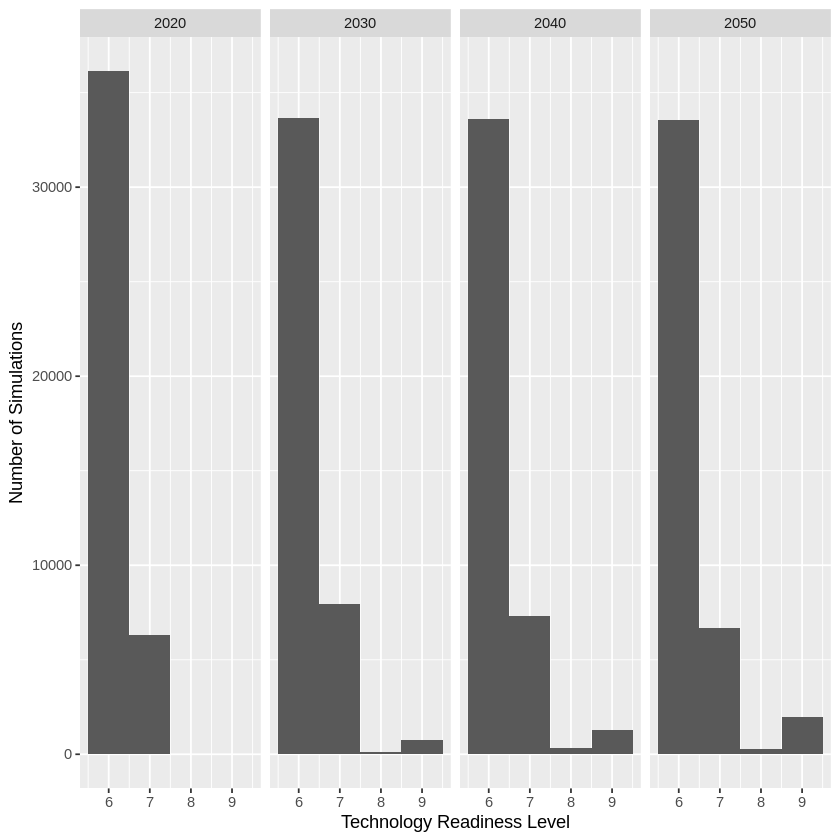

In [5]:
ggplot(z.outputs[Time %in% c(2020,2030,2040,2050)], aes(x=`technology readiness level`)) +
    geom_histogram(bins = 4) +
    facet_grid(. ~ Time) +
    xlab("Technology Readiness Level") +
    ylab("Number of Simulations")
ggsave("trl-by-year.png", width = 6.5, height = 3, units = "in")

## Compute elementary effects.

### Just use the final year.

In [6]:
z.outputs.clean <- z.outputs[order(Run)][`Time` == 2050, c(-1, -2)] %>% as.matrix
z.outputs.clean %>% dim

[1] 42500    49

### Define functions to compute elementary effects.

In [7]:
ind.rep <- function(i, p) {
# indices of the points of the ith trajectory in the DoE
  (1 : (p + 1)) + (i - 1) * (p + 1)
}

ee.oat <- function(X, y) {
  # compute the elementary effects for a OAT design
  p <- ncol(X)
  r <- nrow(X) / (p + 1)
  
#  if(is(y,"numeric")){
  if(inherits(y, "numeric")){
    one_i_vector <- function(i){
      j <- ind.rep(i, p)
      j1 <- j[1 : p]
      j2 <- j[2 : (p + 1)]
      # return((y[j2] - y[j1]) / rowSums(X[j2,] - X[j1,]))
      return(solve(X[j2,] - X[j1,], y[j2] - y[j1]))
    }
    ee <- vapply(1:r, one_i_vector, FUN.VALUE = numeric(p))
    ee <- t(ee)
    # "ee" is now a (r times p)-matrix.
#  } else if(is(y,"matrix")){
  } else if(inherits(y, "matrix")){
    one_i_matrix <- function(i){
      j <- ind.rep(i, p)
      j1 <- j[1 : p]
      j2 <- j[2 : (p + 1)]
      return(solve(X[j2,] - X[j1,], 
                   y[j2, , drop = FALSE] - y[j1, , drop = FALSE]))
    }
    ee <- vapply(1:r, one_i_matrix, 
                 FUN.VALUE = matrix(0, nrow = p, ncol = dim(y)[2]))
    # Special case handling for p == 1 and ncol(y) == 1 (in this case, "ee" is
    # a vector of length "r"):
    if(p == 1 && dim(y)[2] == 1){
      ee <- array(ee, dim = c(r, 1, 1))
    }
    # Transpose "ee" (an array of dimensions c(p, ncol(y), r)) to an array of
    # dimensions c(r, p, ncol(y)) (for better consistency with the standard 
    # case that "class(y) == "numeric""):
    ee <- aperm(ee, perm = c(3, 1, 2))
#  } else if(is(y,"array")){
  } else if(inherits(y, "array")){
    one_i_array <- function(i){
      j <- ind.rep(i, p)
      j1 <- j[1 : p]
      j2 <- j[2 : (p + 1)]
      ee_per_3rd_dim <- sapply(1:(dim(y)[3]), function(idx_3rd_dim){
        y_j2_matrix <- y[j2, , idx_3rd_dim]
        y_j1_matrix <- y[j1, , idx_3rd_dim]
        # Here, the result of "solve(...)" is a (p times dim(y)[2])-matrix or
        # a vector of length dim(y)[2] (if p == 1):
        solve(X[j2,] - X[j1,], y_j2_matrix - y_j1_matrix)
      }, simplify = "array")
      if(dim(y)[2] == 1){
        # Correction needed if dim(y)[2] == 1, so "y_j2_matrix" and
        # "y_j1_matrix" have been dropped to matrices (or even vectors, if also
        # p == 1):
        ee_per_3rd_dim <- array(ee_per_3rd_dim, 
                                dim = c(p, dim(y)[2], dim(y)[3]))
      } else if(p == 1){
        # Correction needed if p == 1 (and dim(y)[2] > 1), so "y_j2_matrix" and
        # "y_j1_matrix" have been dropped to matrices:
        ee_per_3rd_dim <- array(ee_per_3rd_dim, 
                                dim = c(1, dim(y)[2], dim(y)[3]))
      }
      # "ee_per_3rd_dim" is now an array of dimensions 
      # c(p, dim(y)[2], dim(y)[3]). Assign the corresponding names for the 
      # third dimension:
      if(is.null(dimnames(ee_per_3rd_dim))){
        dimnames(ee_per_3rd_dim) <- dimnames(y)
      } else{
        dimnames(ee_per_3rd_dim)[[3]] <- dimnames(y)[[3]]
      }
      return(ee_per_3rd_dim)
    }
    ee <- sapply(1:r, one_i_array, simplify = "array")
    # Special case handling if "ee" has been dropped to a vector:
#    if(is(ee,"numeric")){
    if (inherits(ee, "numeric")){
      ee <- array(ee, dim = c(p, dim(y)[2], dim(y)[3], r))
      dimnames(ee) <- list(NULL, dimnames(y)[[2]], dimnames(y)[[3]], NULL)
    }
    # "ee" is an array of dimensions c(p, dim(y)[2], dim(y)[3], r), so it is
    # transposed to an array of dimensions c(r, p, dim(y)[2], dim(y)[3]):
    ee <- aperm(ee, perm = c(4, 1, 2, 3))
  }
  return(ee)
}

### Elementary effects.

In [8]:
z.ee <- ee.oat(z.design, z.outputs.clean)
z.ee %>% dim

[1] 500  84  49

### mu, mu*, and sigma.

In [9]:
z.mu <- apply(z.ee, 3, function(M){
  apply(M, 2, mean)
})
z.mu <- melt(
    cbind(
        data.table(Input=rownames(z.mu)),
        data.table(z.mu)
    ),
    id.vars="Input",
    variable.name = "Output",
    value.name = "mu"
)
z.mu %>% head

Input,Output,mu
<chr>,<fct>,<dbl>
advertising budget,bioproduct market share mass,0.303273857
advertising start time,bioproduct market share mass,-0.387986934
aversion to NPV deviation,bioproduct market share mass,-0.001418284
base external investor ask rate,bioproduct market share mass,-0.023685767
bioproduct long term price,bioproduct market share mass,-0.160606092
bioproduct offtake agreement,bioproduct market share mass,0.512129831


In [10]:
z.mu.star <- apply(abs(z.ee), 3, function(M){
  apply(M, 2, mean)
})
z.mu.star <- melt(
    cbind(
        data.table(Input=rownames(z.mu.star)),
        data.table(z.mu.star)
    ),
    id.vars="Input",
    variable.name = "Output",
    value.name = "mu*"
)
z.mu.star %>% head

Input,Output,mu*
<chr>,<fct>,<dbl>
advertising budget,bioproduct market share mass,0.31027692
advertising start time,bioproduct market share mass,0.41195148
aversion to NPV deviation,bioproduct market share mass,0.01152693
base external investor ask rate,bioproduct market share mass,0.26447606
bioproduct long term price,bioproduct market share mass,0.39980623
bioproduct offtake agreement,bioproduct market share mass,0.77572582


In [11]:
z.sigma <- apply(z.ee, 3, function(M){
  apply(M, 2, sd)
})
z.sigma <- melt(
    cbind(
        data.table(Input=rownames(z.sigma)),
        data.table(z.sigma)
    ),
    id.vars="Input",
    variable.name = "Output",
    value.name = "sigma"
)
z.sigma %>% head

Input,Output,sigma
<chr>,<fct>,<dbl>
advertising budget,bioproduct market share mass,1.1085135
advertising start time,bioproduct market share mass,1.4664525
aversion to NPV deviation,bioproduct market share mass,0.1115146
base external investor ask rate,bioproduct market share mass,0.6278341
bioproduct long term price,bioproduct market share mass,1.7387415
bioproduct offtake agreement,bioproduct market share mass,4.5942430


In [12]:
z.results <- merge(merge(z.mu, z.mu.star, on=c("Input", "Output")), z.sigma, on=c("Input", "Output"))
z.results %>% head

Input,Output,mu,mu*,sigma
<chr>,<fct>,<dbl>,<dbl>,<dbl>
advertising budget,bioproduct market share mass,3.032739e-01,3.102769e-01,1.108513e+00
advertising budget,current market size economic,-2.412707e+11,9.415770e+11,4.866741e+12
advertising budget,current market size mass,0.000000e+00,0.000000e+00,0.000000e+00
advertising budget,long term market share,-6.742848e-04,1.255821e-03,1.507683e-02
advertising budget,long term market value,-3.252294e+08,3.252294e+08,7.252179e+09
advertising budget,Adopters,4.651019e+07,5.092098e+07,1.587423e+08


In [13]:
z.results[, `:=`(
    `mu rank`    = frank(- `mu`   ),
    `mu* rank`   = frank(- `mu*`  ),
    `sigma rank` = frank(- `sigma`)
), by=.(Output)]
z.results %>% head

Input,Output,mu,mu*,sigma,mu rank,mu* rank,sigma rank
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
advertising budget,bioproduct market share mass,3.032739e-01,3.102769e-01,1.108513e+00,3,15,24
advertising budget,current market size economic,-2.412707e+11,9.415770e+11,4.866741e+12,80,23,25
advertising budget,current market size mass,0.000000e+00,0.000000e+00,0.000000e+00,43,44,44
advertising budget,long term market share,-6.742848e-04,1.255821e-03,1.507683e-02,64,49,51
advertising budget,long term market value,-3.252294e+08,3.252294e+08,7.252179e+09,71,30,24
advertising budget,Adopters,4.651019e+07,5.092098e+07,1.587423e+08,6,13,23


In [14]:
z.results[Input %in% c(
    'aversion to NPV deviation'
,   'base external investor ask rate'
,   'bioproduct long term price'
,   'bioproduct performance advantage'
,   'commercial capital cost input'
,   'commercial plant capacity'
,   'commercial plant capacity input'
,   'commercial process yield input'
,   'commercial variable operating cost input'
,   'expected continuity of government policy'
,   'government capital cost share'
,   'government production incentive'
,   'initial market size'
,   'management response time'
,   'market growth rate'
,   'minimum runway'
,   'number of missed stagegates allowed'
,   'payback period multiplier'
,   'pilot and demo response time'
,   'pilot capacity'
,   'piloting acceptable rate'
,   'piloting failure default recovery time'
,   'piloting failure distribution max'
,   'random stream'
,   'required internal return'
,   'required return multiplier'
,   'researching impact on piloting'
,   'startup piloting period'
,   'startup piloting rate'
,   'strategic value to external investors'
,   'target demo hours'
,   'target pilot hours'
), .(
    `Minimum mu* rank` = min(`mu* rank`),
    `Minimum sigma rank` = min(`sigma rank`)
), by = Input
][order(`Minimum mu* rank` + `Minimum sigma rank`)]

Input,Minimum mu* rank,Minimum sigma rank
<chr>,<dbl>,<dbl>
bioproduct performance advantage,1.0,1.0
commercial variable operating cost input,1.0,1.0
random stream,1.0,1.0
bioproduct long term price,1.0,2.0
commercial plant capacity,1.5,1.5
initial market size,1.0,2.0
piloting acceptable rate,2.0,1.0
base external investor ask rate,2.0,2.0
commercial plant capacity input,2.0,2.0


## Input and output categories.

In [15]:
categories.input <- fread("categories-inputs.tsv")
categories.input[, unique(`Input Category`)]

[1] "Bioproduct Price"      "Commercial Technology" "Demo Technology"      
 [4] "Demoing"               "Feedstock Price"       "Government Incentives"
 [7] "Investor Behavior"     "Management Behavior"   "Market"               
[10] "Piloting"              "Randomization"         "Regulatory Approval"

In [16]:
categories.output <- fread("categories-outputs.tsv")
categories.output[, unique(`Output Category`)]

[1] "Business Metrics"      "Commercialization"     "Demoing"              
[4] "Government Incentives" "Investment Metrics"    "Market"               
[7] "Piloting"              "Regulatory Approval"

In [17]:
z.results.categorized <- merge(
    merge(
        z.results
    ,   categories.input
    ,   by = "Input"
    )
,   categories.output
,   by = "Output"
)[, .(
    `mu median rank`  = median(`mu rank`)
,   `mu* median rank` = median(`mu* rank`)
,   `sigma median rank`  = median(`sigma rank`) #σ
)
,   by = .(
    Input  = `Input Category`
,   Output = `Output Category`
)]

## Heat map for mu*.

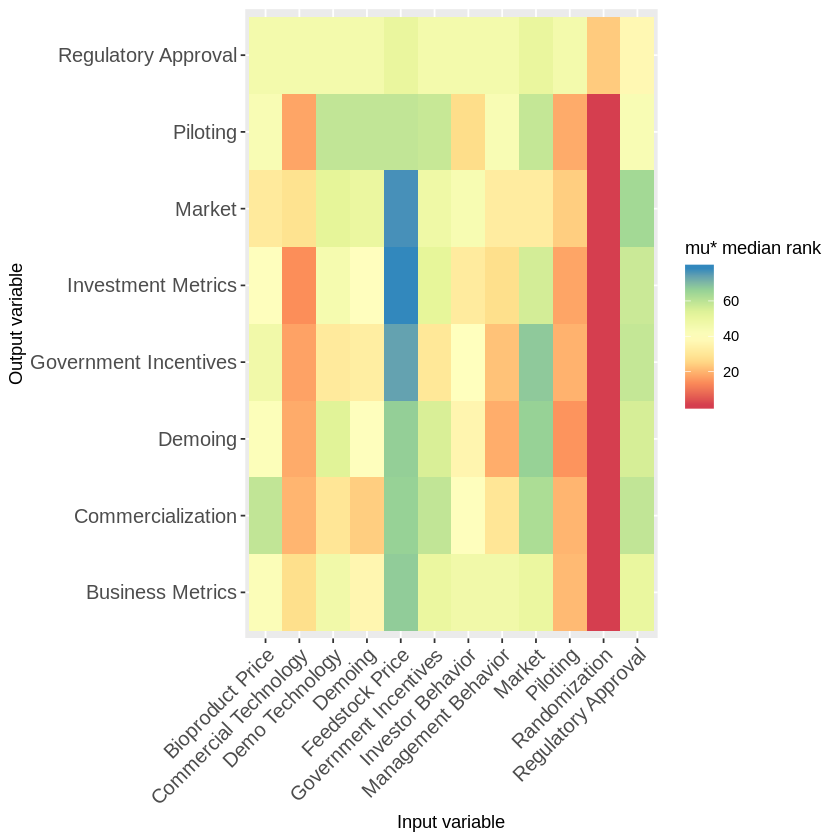

In [18]:
ggplot(
    z.results.categorized,
    aes(
        x=Input,
        y=Output,
        fill=`mu* median rank`
    )
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", direction = 1) +
    xlab("Input variable") +
    ylab("Output variable") +
    theme(
        axis.text=element_text(size = 12),
        axis.text.x = element_text(angle = 45, hjust = 1)
    )
ggsave("mustar-io-category.png", width = 6.5, height = 4.0, units = "in")

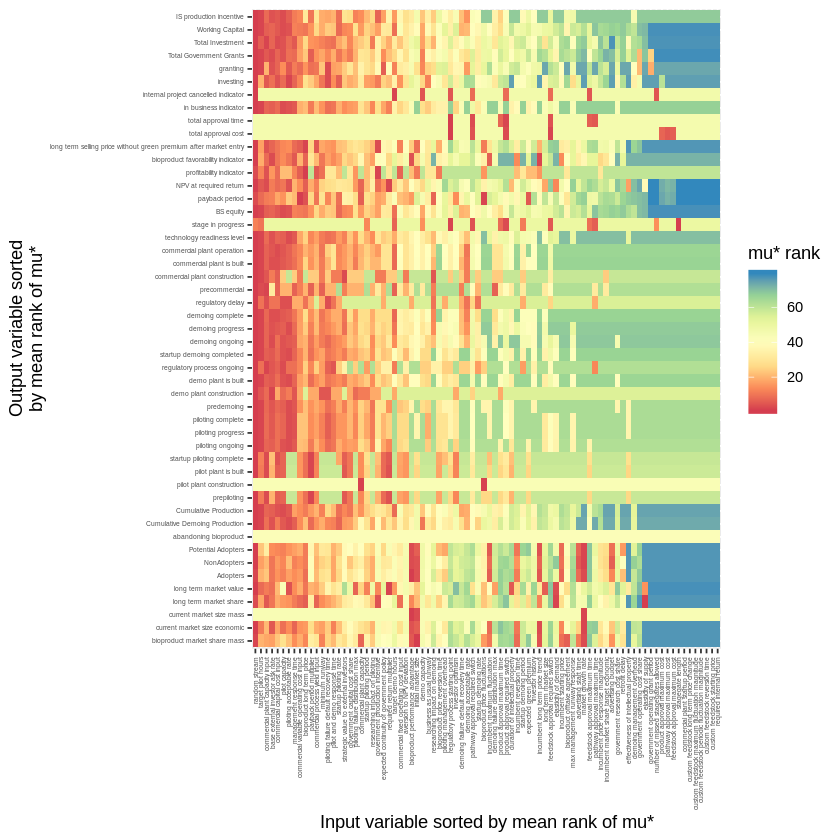

In [19]:
ggplot(
    z.results,
    aes(
        y=factor(
            Output,
            levels=z.results[, .(`sort` = mean(`mu* rank`)), by=.(Output)][order(sort), `Output`]
        ),
        x=factor(
            Input,
            levels=z.results[, .(`sort` = mean(`mu* rank`)), by=.(Input)][order(sort), `Input`]
        ),
        fill=`mu* rank`
    )
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", direction = 1) +
    xlab("Input variable sorted by mean rank of mu*") +
    ylab("Output variable sorted\nby mean rank of mu*") +
    theme(
        axis.text=element_text(size = 4),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)
    )
ggsave("mustar-io-variable.png", width = 6.5, height = 4.0, units = "in")

## Heat map for sigma.

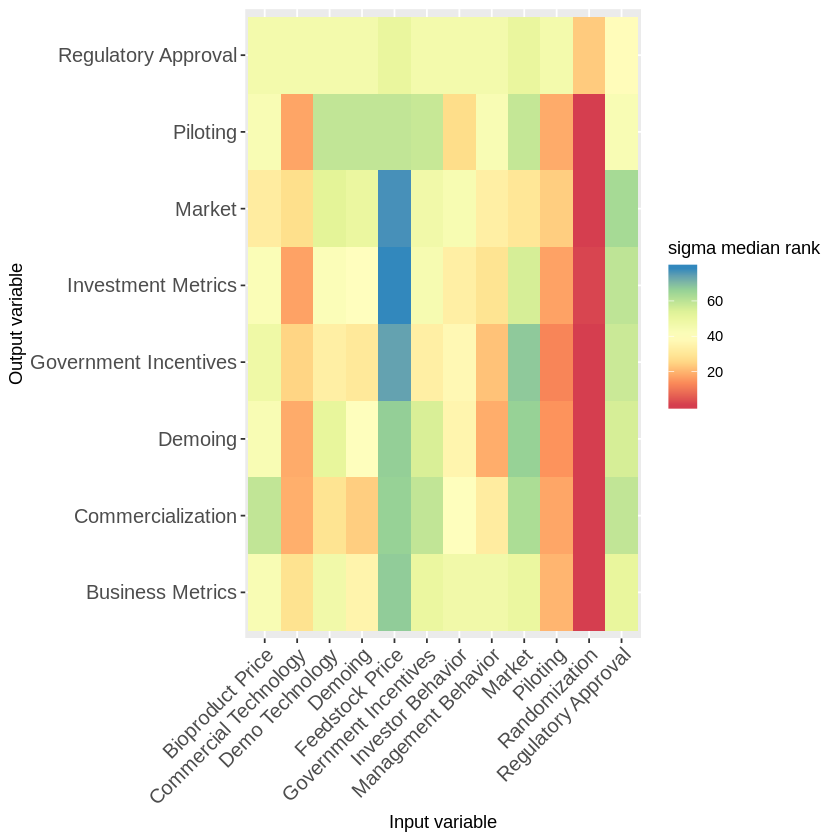

In [20]:
ggplot(
    z.results.categorized,
    aes(
        x=Input,
        y=Output,
        fill=`sigma median rank`
    )
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", direction = 1) +
    xlab("Input variable") +
    ylab("Output variable") +
    theme(
        axis.text=element_text(size = 12),
        axis.text.x = element_text(angle = 45, hjust = 1)
    )
ggsave("sigma-io-category.png", width = 6.5, height = 4.0, units = "in")

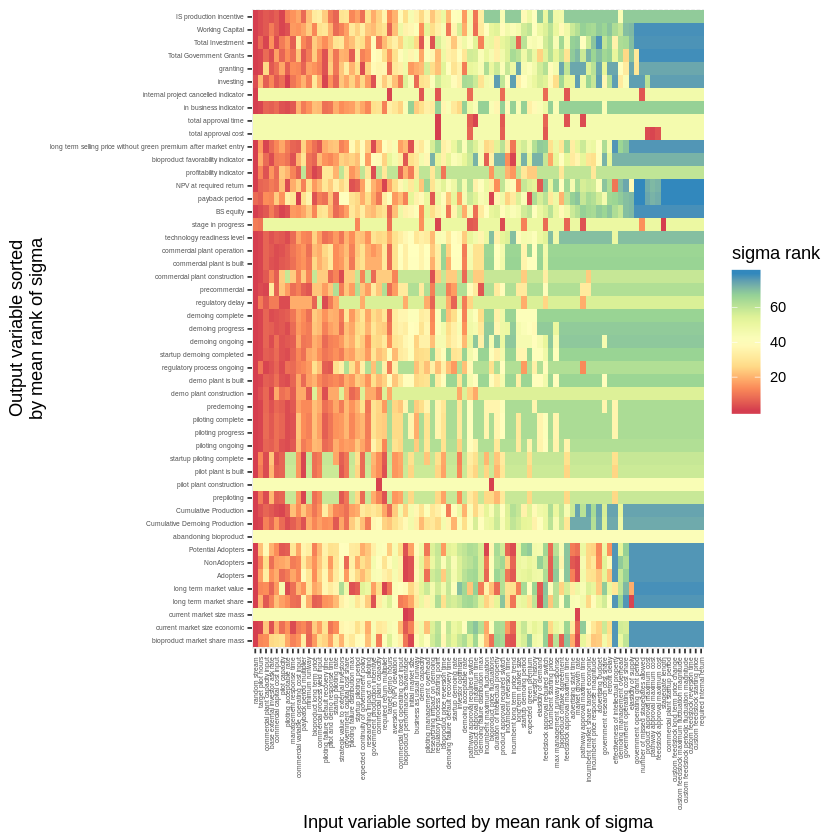

In [21]:
ggplot(
    z.results,
    aes(
        y=factor(
            Output,
            levels=z.results[, .(`sort` = mean(`sigma rank`)), by=.(Output)][order(sort), `Output`]
        ),
        x=factor(
            Input,
            levels=z.results[, .(`sort` = mean(`sigma rank`)), by=.(Input)][order(sort), `Input`]
        ),
        fill=`sigma rank`
    )
) +
    geom_tile() +
    scale_fill_distiller(palette = "Spectral", direction = 1) +
    xlab("Input variable sorted by mean rank of sigma") +
    ylab("Output variable sorted\nby mean rank of sigma") +
    theme(
        axis.text=element_text(size = 4),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)
    )
ggsave("sigma-io-variable.png", width = 6.5, height = 4.0, units = "in")